# Point Source Detection on a Spherical Patch with the CWT
In the previous notebook, we partitioned the sphere into approximately patches. By projecting these patches and the data contained inside it, we can use the CWT to perform a point source search, as we showed in the first notebook. Moreover, by having these small flat patches, the scale parameter of the CWT will align closely to the angular scale of the wavelet.

## Load Projected Data

In [1]:
import sys, os, time, fileinput
sys.path.append("..")
from utils import _maps as maps
from utils import _wavelets as wt

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from scipy.integrate import quad
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('default') 

import healpy as hp
import astropy as ap
import astropy.units as u
from astropy_healpix import HEALPix

In [2]:
# set the number of pixels in the map
NSIDE = 4
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
NPIX = hp.nside2npix(NSIDE)
print("Number of Pixels: {}".format(NPIX))

# after loading the data, all we need to do is be sure the angular coordinates are written in terms
# of longitude ([0,2\pi]) and latitude (-\pi, \pi)
## source: gce/notebooks/sections_of_sphere_to_plane_v2

# generate random points on plane around a pixel and see detect points inside it
# project boundaries into square region in plane tangent to center point

arr_edge_points = maps.healpix_edge_generator_(NSIDE = 4, step = 100)
arr_c = maps.father_pixel_center_generator_(arr_edge_points)

Approximate resolution at NSIDE 4 is 1.5e+01 deg
Number of Pixels: 192


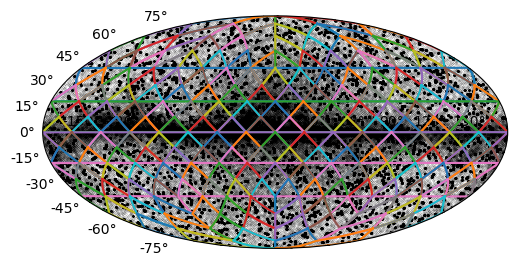

In [4]:
# load local directory
map_dir = "../data/maps/bkgd_wps_0/"

events = np.load(map_dir + 'map.npy', allow_pickle = True)
l_events = events[:,0]
b_events = events[:,1]

phi_events = l_events.copy()
phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi

fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111, projection='mollweide')
ax.scatter(phi_events,b_events, s = 0.01, c = 'k', alpha = 0.5)
for npix in range(NPIX):
    ax.plot(arr_edge_points[npix, :, 0] - np.pi, arr_edge_points[npix, :, 1])


Text(0, 0.5, '$y$ (rad)')

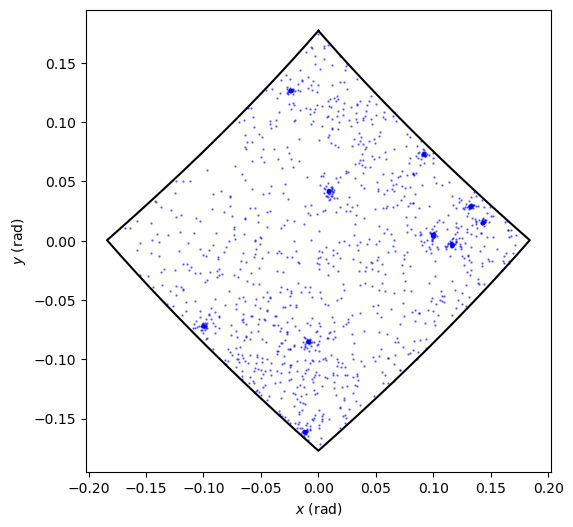

In [8]:
npix = 58

# extract latitudes and longitudes of father pixel edges and centers
lon_edge = arr_edge_points[npix, :, 0] ; lat_edge = arr_edge_points[npix, :, 1]
lon_c = arr_c[npix, 0] ; lat_c = arr_c[npix, 1]

# project boundaries into flat region in plane tangent to center point
r_edge = maps.tangent_plane_proj_(lat_edge, lon_edge, lat_c, lon_c)
x_edge = r_edge[:,0] ; y_edge = r_edge[:,1]

# data needs to be in same coordinate system as pixels
lon_events = phi_events + np.pi
lat_events = b_events

# find points inside pixel
lon_pix, lat_pix = maps.find_points_inside_pixel_(lon_events, lat_events, npix, lon_edge, lat_edge, NSIDE=4, step=100)

# plot patch and points in Mollweide projection
phi_pix = lon_pix - np.pi
phi_edge = lon_edge - np.pi

# project datapoints into flat region in plane tangent to center point
r_pix = maps.tangent_plane_proj_(lat_pix, lon_pix, lat_c, lon_c)
x_pix = r_pix[:,0] ; y_pix = r_pix[:,1]

fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111)

ax.scatter(x_pix,y_pix, c = 'b', alpha = 0.5, s = 0.5)
ax.plot(x_edge,y_edge, c = 'k')
ax.set_xlabel('$x$ (rad)')
ax.set_ylabel('$y$ (rad)')

## Processing Before Performing CWT
### Improving CWT Calculation
Recall from the first notebook, the CWT is estimated by the datapoints:
$$ \begin{aligned} 
W_\psi(a,\vec{b}) & = \frac{1}{a} \int d^{2}x \ f(\vec{x}) \ \bar{\psi} \left ( \frac{\vec{x} - \vec{b}}{a} \right ) \\ 
& \sim \frac{1}{a}\times \frac{1}{N} \sum_{i} \bar{\psi} \left ( \frac{\vec{x_{i}} - \vec{b}}{a} \right ),  
\end{aligned} $$

So far, we cannot perform the CWT for each projected father pixel and expect valid results. Regarding the CWT calculation, the "true" CWT at a point inside a given father pixel depends on points outside the father pixel. Without that data, the CWT will vanish near the boundaries of the pixels.

Since these issues are related to the presence of a boundary, we resolve it in the following way. Using the available data, we can find all points that are a given angular distance away from the father pixel. We take this distance to be $\sim 4^{\circ}$, as the base Mexican Hat Wavelet is very small relative to its local min/max for $r > 5$. Since we found wavelets of scales $\gtrsim 0.8^{\circ}$ do not perform well at discriminating sources from background, this is a reasonable starting point. A more careful analysis should show that the list of candidate point sources does not strongly depend on increases to this angular scale. This creates a band of data surrounding the father pixel. 

Text(0, 0.5, '$y$ (rad)')

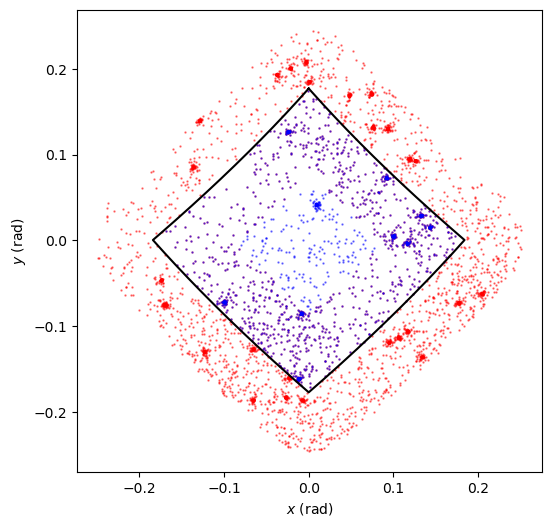

In [10]:
# define second outer band of points outside each group (for wavelet accuracy at boundary of pixels)
ang_scale = 4 * np.pi / 180
lon_outmost, lat_outmost = maps.find_neighboring_points_(ang_scale, lon_events, lat_events, lon_edge, lat_edge)
r_outmost = maps.tangent_plane_proj_(lat_outmost, lon_outmost, lat_c, lon_c)
x_outmost = r_outmost[:,0] ; y_outmost = r_outmost[:,1]

fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111)

ax.scatter(x_outmost,y_outmost, c = 'r', alpha = 0.5, s = 0.5)
ax.scatter(x_pix,y_pix, c = 'b', alpha = 0.5, s = 0.5)
ax.plot(x_edge,y_edge, c = 'k')
ax.set_xlabel('$x$ (rad)')
ax.set_ylabel('$y$ (rad)')

## Associating Wavelet Peaks with Point Sources
We associate sufficiently bright peaks in the wavelet map with point sources. We identify peaks with the `skimage.peak_local_max`, described further in `extra/allsky_search/notes.pdf`. This algorithm uses a maximum filter, which will more likely fail to detect point sources at the boundary. Therefore, we should not be calculating wavelet transformations near the boundary of our dataset.

By including these extra points in our CWT calculations, we calculate more accurate estimates of the CWT near the edges of a father pixel. However, for the peak identification algorithm, the issue is not including data that is outside the boundary. It is merely not having any grid points outside the boundary. The question now is how we should define grid points that are outside the father pixel. To do this, we actually make use of the surrounding points. If the data is reasonably dense outside the father pixel, the boundary of the data will define a curve that encloses the father pixel. These curves are well-behaved for the background maps that we have used so far. We can use this boundary to define a larger set of grid points for the CWT calculation, which are inside and outside of the father pixel. In practice, we consider the boundary of points that are $\sim 2^{\circ}$ away from the father pixel since the only role these grid points serve is for the peak identifier to perform well on the actual boundaries of the father pixel.

The boundary of the dataset is generated using the `maps.find_neighboring_points_` function that uses the *alpha shape* (or *concave hull*) formalism. For more details, see the documentation of the function.

Text(0, 0.5, '$y$ (rad)')

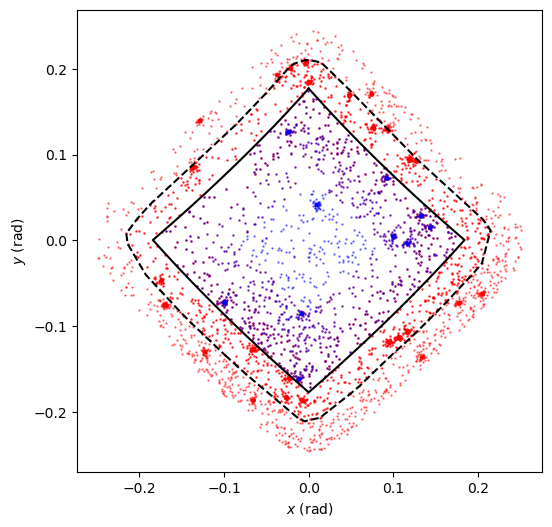

In [11]:
# generate first outer band of points outside each group 
ang_scale = 2 * np.pi / 180
lon_out, lat_out = maps.find_neighboring_points_(ang_scale, lon_events, lat_events, lon_edge, lat_edge)
r_out = maps.tangent_plane_proj_(lat_out, lon_out, lat_c, lon_c)

# generate boundary of band used for grid generation
x_out = r_out[:,0] ; y_out = r_out[:,1]
r_outer_edge = maps.generate_edge_of_point_set_(x_out, y_out)
x_outer_edge = r_outer_edge[:,0] ; y_outer_edge = r_outer_edge[:,1]

fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111)

ax.scatter(x_outmost,y_outmost, c = 'r', alpha = 0.5, s = 0.5)
ax.scatter(x_out,y_out, c = 'r', alpha = 0.5, s = 0.5)
ax.scatter(x_pix,y_pix, c = 'b', alpha = 0.5, s = 0.5)
ax.plot(x_outer_edge,y_outer_edge, c = 'k', ls = '--')
ax.plot(x_edge,y_edge, c = 'k')
ax.set_xlabel('$x$ (rad)')
ax.set_ylabel('$y$ (rad)')

## Generate a Coarse Grid as an Example

Text(0, 0.5, '$y$ (rad)')

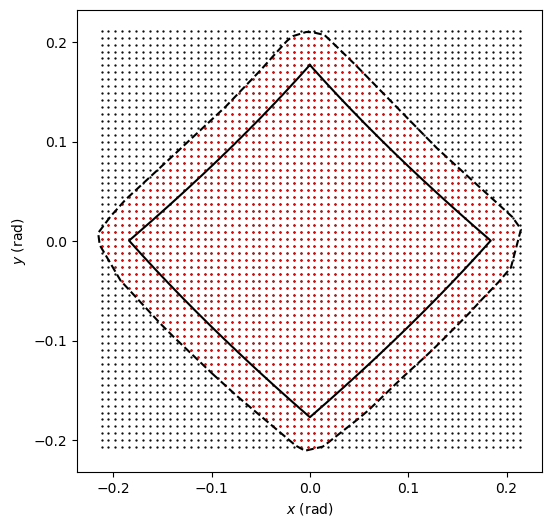

In [13]:
# decided to separate grid and projected maps into two different dictionaries
# grid is defined using the total background map for all energies
grid_scale_deg = 0.4

grid, mesh_bxby, arr_b, grid_flat, arr_bx_plot, arr_by_plot = maps.generate_grid_points_(x_outer_edge, y_outer_edge, 
                                                                                         grid_scale_deg * np.pi / 180, True)

fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111)

plt.scatter(arr_b[:,0], arr_b[:,1], s = 0.4, c = 'k')
plt.scatter(arr_b[grid_flat,0], arr_b[grid_flat,1], c = 'r', s = 0.4)
plt.plot(x_outer_edge, y_outer_edge, c = 'k', ls = '--')
ax.plot(x_edge,y_edge, c = 'k')
ax.set_xlabel('$x$ (rad)')
ax.set_ylabel('$y$ (rad)')

### Summary
Our data for the search in the father pixel consists of the following regions:
1. Within the father pixel, where we search for point sources (search region)
2. Within $2^{\circ}$ of the father pixel, where we define our grid of translations to form the CWT map (outer region)
3. Within $4^{\circ}$ of the father pixel, used to compute the wavelet coefficients at each grid point (outmost region)

In practice, we define the outer region and outmost regions as bands that share no data with each other or the search region.

In [15]:
# create projected map dictionary
projected_map = {}
projected_map['center_coords'] = arr_c[npix,:]
projected_map['search_region_points'] = r_pix
projected_map['search_region_edge'] = r_edge
projected_map['outer_region_points'] = maps.remove_points_from_array_(r_out,r_pix)
projected_map['outer_region_edge'] = r_outer_edge

r_pix_and_out_redundant = np.concatenate((r_pix, r_out), axis = 0) # combine
_, unique_indices = np.unique(r_pix_and_out_redundant, axis = 0, return_index = True) # find unique points
r_pix_and_out = r_pix_and_out_redundant[unique_indices,:]  # remove duplicates

r_all_redundant = np.concatenate((r_pix_and_out,r_outmost), axis = 0) # combine
_, unique_indices = np.unique(r_all_redundant, axis = 0, return_index = True) # find unique points
r_all = r_all_redundant[unique_indices,:] # remove duplicates

projected_map['all_points'] = r_all
projected_map['outmost_region_points'] = maps.remove_points_from_array_(r_all,r_pix_and_out)

## Generate Wavelet Map

In [19]:
# load data
data = projected_map['all_points']

# decided to separate grid and projected maps into two different dictionaries
# grid is defined using the total background map for all energies
grid_scale_deg = 0.1
grid, mesh_bxby, arr_b, grid_flat, arr_bx_plot, arr_by_plot = maps.generate_grid_points_(x_outer_edge, y_outer_edge, 
                                                                                         grid_scale_deg * np.pi / 180, True)

# load scale parameter
a_deg = 0.6
a = a_deg * np.pi / 180
arr_a = np.array([a])
Na = len(arr_a)

# define 2d wavelet
wavelet_name = 'mexh'
mexh = wt._2d_wavelet(wavelet_name)

# pre-allocate wavelet coefficient map 
N_data, N_dim = data.shape
Ny, Nx = mesh_bxby.shape[:-1]
coefficient_map = np.zeros((Ny, Nx, Na))

# broadcast arrays in wavelet calculation
buf_data = data[np.newaxis,np.newaxis,np.newaxis]
buf_mesh_bxby = mesh_bxby[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

# calculate arguments of wavelet coefficients
# buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_arg_grid =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )[grid]

# calculate wavelet coefficients
buf_mexh_output_grid = mexh.base_fct(buf_arr_arg_grid)

# remove two dimensions of a-array to divide mexh
buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

# estimate wavelet coefficient by summing over datapoints
coefficient_map_flat = np.sum(buf_mexh_output_grid, axis = -1) / buf_arr_a_sq / N_data
coefficient_map_flat_sq = np.squeeze(coefficient_map_flat, axis = -1)

# note that buf_arr_arg_grid is flattened relative to the shape of mesh_bxby
# applying grid to coefficient_map automatically flattens coefficient_map to match to coefficient_map_flat_sq
coefficient_map[grid] = coefficient_map_flat_sq                      

(-0.21536225821989896,
 0.21573406702270104,
 -0.21083441749918405,
 0.2115352614834443)

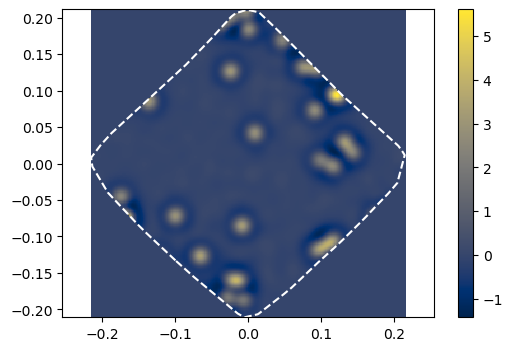

In [20]:
cwt_map = coefficient_map

fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map[:,:,0]), 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.colorbar(plot)
ax.plot(x_outer_edge, y_outer_edge, c = 'w', ls = '--')
ax.axis('equal')

### Threshold Map with $W_{\psi} > 1$

(-0.21536225821989896,
 0.21573406702270104,
 -0.21083441749918405,
 0.2115352614834443)

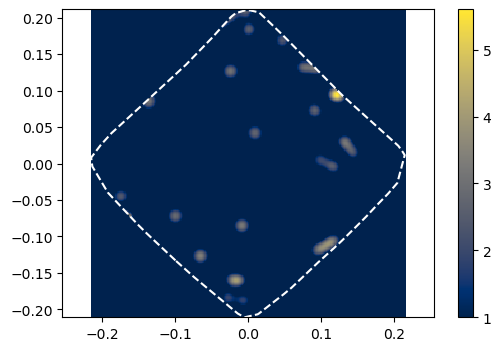

In [22]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=1, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.colorbar(plot)
ax.plot(x_outer_edge, y_outer_edge, c = 'w', ls = '--')
ax.axis('equal')

In [23]:
S0 = 1
cwt_map_thresh = np.copy(cwt_map[:,:,0])
thresh_map = (cwt_map_thresh > S0)
cwt_map_thresh[~thresh_map] = 0

## Search for Point Sources with Skimage Peak Finder

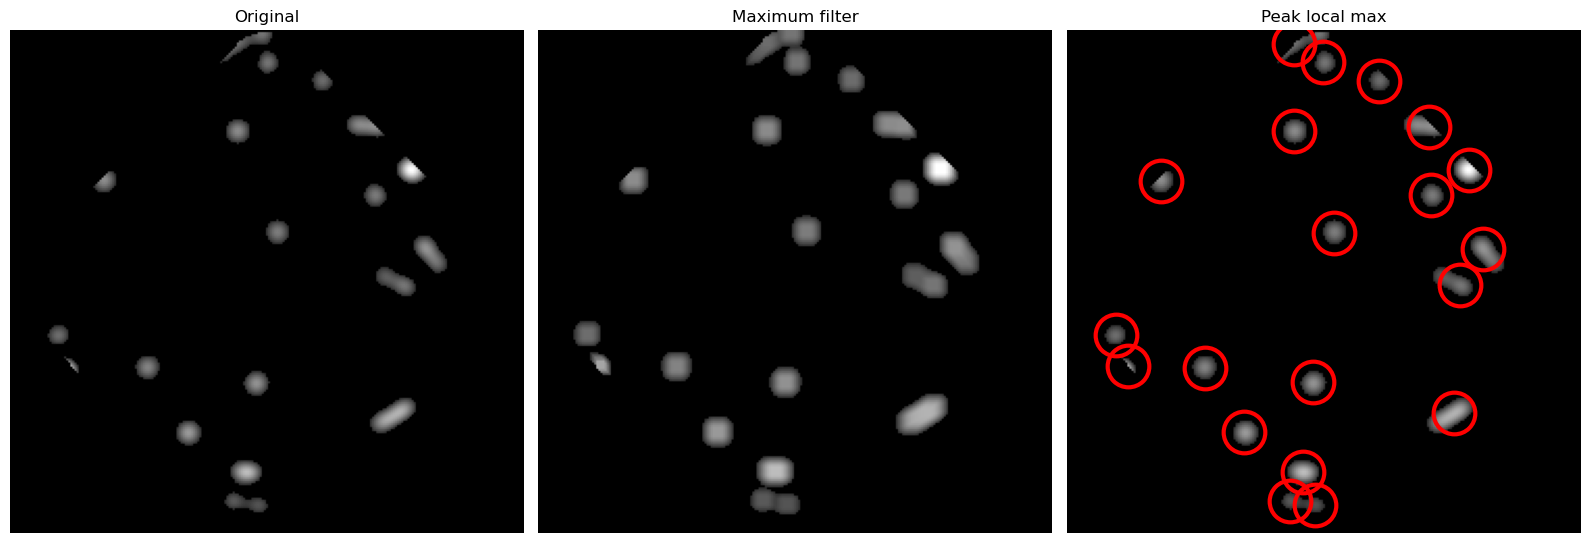

In [24]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

# single a-value 
psf_degree = 0.4 
psf_scale = psf_degree * np.pi / 180
grid_scale = 0.1 * np.pi / 180
N_pix_psf = int(psf_scale / grid_scale)

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(cwt_map_thresh, size=N_pix_psf, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(cwt_map_thresh, min_distance=N_pix_psf, 
                             threshold_abs = S0)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8*2, 6))
ax = axes.ravel()
ax[0].imshow(cwt_map_thresh, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')
ax[0].invert_yaxis()

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')
ax[1].invert_yaxis()

ax[2].imshow(cwt_map_thresh, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'ro', markersize = 30, markerfacecolor = 'none', markeredgewidth = 3)
ax[2].axis('off')
ax[2].set_title('Peak local max')
ax[2].invert_yaxis()

fig.tight_layout()

plt.show()

### Restrict Search to Inside Father Pixel
Point sources detected that are outside the father pixel would be found during a search in the father pixel that actually contains it.

In [25]:
arr_bx = 0.5 * (arr_bx_plot[:-1] + arr_bx_plot[1:])
arr_by = 0.5 * (arr_by_plot[:-1] + arr_by_plot[1:])

nx = coordinates[:,1]
ny = coordinates[:,0]

pos_x = arr_bx[nx]
pos_y = arr_by[ny]

arr_edge_points = projected_map['search_region_edge']
x_edge = arr_edge_points[:,0] ; y_edge = arr_edge_points[:,1]
x_in, y_in = maps.find_points_inside_curve_(pos_x, pos_y, x_edge, y_edge)

(-0.21536225821989896,
 0.21573406702270104,
 -0.21083441749918405,
 0.2115352614834443)

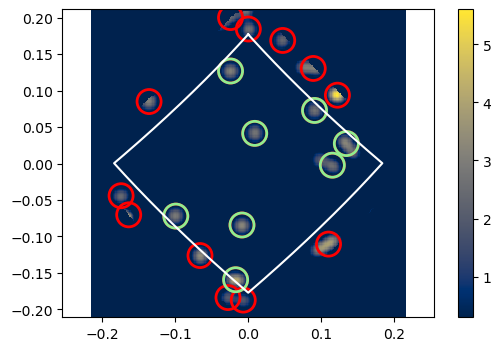

In [26]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

nx = coordinates[:,1]
ny = coordinates[:,0]

pos_x = arr_bx[nx]
pos_y = arr_by[ny]

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0.3, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.plot(x_edge, y_edge, c = 'white')
plt.scatter(pos_x, pos_y, facecolors = 'none', edgecolors = 'r', linewidths = 2, s = 300)
plt.scatter(x_in, y_in, facecolors = 'none', edgecolors = 'lightgreen', linewidths = 2, s = 300)
plt.colorbar(plot)
ax.axis('equal')

### Project Locations of Point Sources and Compare with Injected Point Sources

In [27]:
# project detected locations to sphere
lon_c, lat_c = projected_map['center_coords']
r_ps = np.array([maps.inv_tangent_plane_proj_(x_in[n], y_in[n], lon_c, lat_c) for n in range(len(x_in))])

# load isolated point source data
ps_unprojected_patches_file = map_dir + 'ps_unprojected_patches.npz'
ps_u_data = np.load(ps_unprojected_patches_file, allow_pickle = True)
ps_arr_edge_points, ps_grouped_points_lon, ps_grouped_points_lat, arr_c = [ps_u_data[k] for k in ps_u_data]

# project each group of points into their respective tangent plane
lon_ps = ps_grouped_points_lon[npix]
phi_ps = lon_ps - np.pi
lat_ps = ps_grouped_points_lat[npix]

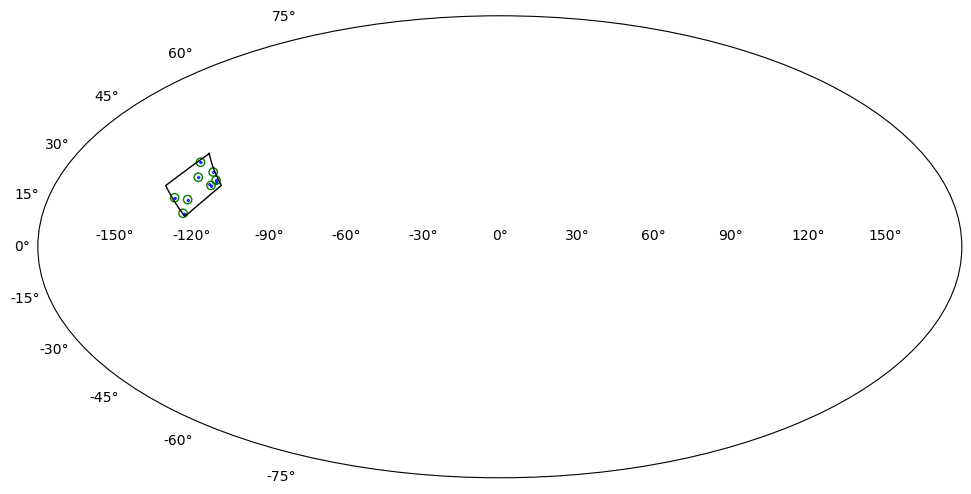

In [28]:
fig = plt.figure(1,figsize=(12,6))
ax = fig.add_subplot(111, projection='mollweide')

ax.scatter(phi_ps,lat_ps, s = 0.001, c = 'b', alpha = 0.5)
plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'g')
ax.plot(phi_edge, lat_edge, c = 'k', lw = 1)

For more information, refer to `extra/allsky_search` directory and notes therein.